In [35]:
import numpy as np
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
from scipy.spatial.distance import cdist
import itertools
import time
import matplotlib.cm as cm
from collections.abc import Collection
from copy import deepcopy
from importlib import reload
import patahistory as p
import time
reload(p);

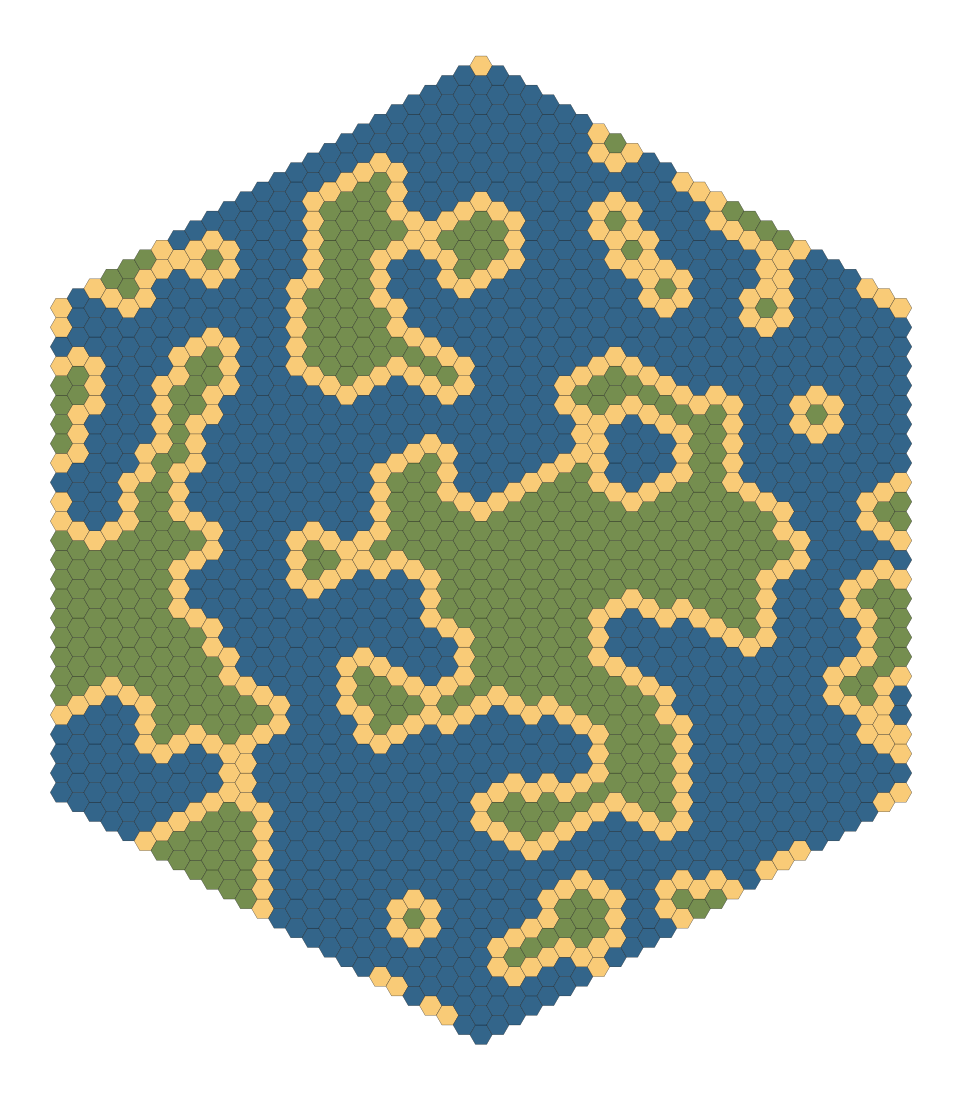

In [42]:
tic = time.time()
grid = p.Grid(25)
toc1 = time.time()
grid.land_and_water(land_coef=.50)
toc2 = time.time()
p.draw_map(grid)
toc3 = time.time()

In [43]:
print(f'Generating the grid took {toc1 - tic}.')
print(f'Generating the land took {toc2 - toc1}.')
print(f'Generating the map took {toc3 - toc2}.')

Generating the grid took 0.06274986267089844.
Generating the land took 0.6860473155975342.
Generating the map took 0.7153410911560059.


In [5]:
print(f'Generating the grid took {toc1 - tic}.')
print(f'Generating the land took {toc2 - toc1}.')
print(f'Generating the map took {toc3 - toc2}.')

Generating the grid took 0.0021643638610839844.
Generating the land took 4.852087736129761.
Generating the map took 0.7335891723632812.


In [5]:
x = np.array([1,2,3,4,5])

np.isin(x, np.array([1,2,3]))

array([ True,  True,  True, False, False])

In [6]:
from timeit import timeit

In [11]:
timeit(stmt='np.isin(x, y)', setup='import numpy as np \nx = np.array([1,2,3,4,5]) \ny = np.array([1,2,3])')

11.33080104399994

In [16]:
timeit(stmt='[i for i in x if i in {1,2,3}]', setup='import numpy as np \nx = np.array([1,2,3,4,5])')

1.8198622810000415

In [15]:
timeit(stmt='f(x)', setup='import numpy as np \nx = np.array([1,2,3,4,5])\nf = np.vectorize(lambda a: a in {1,2,3})')


10.164746917999992

In [18]:
timeit(stmt='[i for i in x if i in {1,2,3}]', setup='import numpy as np \nx = np.array([1,2,3,4,5])')

1.81821686100011